In [1]:
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim

import torchvision.transforms as transforms
import torchvision

from fastprogress import master_bar, progress_bar

from PIL import Image

import math
import torch.nn.functional as F

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

In [2]:
IMAGE_SIZE = 224                              # Image size (224x224)
IMAGENET_MEAN = [0.485, 0.456, 0.406]         # Mean of ImageNet dataset (used for normalization)
IMAGENET_STD = [0.229, 0.224, 0.225]          # Std of ImageNet dataset (used for normalization)
BATCH_SIZE = 120                           
LEARNING_RATE = 0.001
LEARNING_RATE_SCHEDULE_FACTOR = 0.1           # Parameter used for reducing learning rate
LEARNING_RATE_SCHEDULE_PATIENCE = 5           # Parameter used for reducing learning rate
MAX_EPOCHS = 45

**Import Path**

In [3]:
# Define path to the data directory
data_dir = Path('../input/chest_xray/chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

**Load img**

For training

In [4]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))
# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['path', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,path,label
0,../input/chest_xray/chest_xray/train/PNEUMONIA...,1
1,../input/chest_xray/chest_xray/train/PNEUMONIA...,1
2,../input/chest_xray/chest_xray/train/PNEUMONIA...,1
3,../input/chest_xray/chest_xray/train/PNEUMONIA...,1
4,../input/chest_xray/chest_xray/train/PNEUMONIA...,1


For valid

In [5]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
valid_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    valid_data.append((img, 0))
# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    valid_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
valid_data = pd.DataFrame(valid_data, columns=['path', 'label'],index=None)

# Shuffle the data 
valid_data = valid_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
valid_data.head()

,path,label
0,../input/chest_xray/chest_xray/val/NORMAL/NORM...,0
1,../input/chest_xray/chest_xray/val/NORMAL/NORM...,0
2,../input/chest_xray/chest_xray/val/NORMAL/NORM...,0
3,../input/chest_xray/chest_xray/val/PNEUMONIA/p...,1
4,../input/chest_xray/chest_xray/val/PNEUMONIA/p...,1


For testing

In [6]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
test_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    test_data.append((img, 0))
# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    test_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
test_data = pd.DataFrame(test_data, columns=['path', 'label'],index=None)

# Shuffle the data 
test_data = test_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
test_data.head()

,path,label
0,../input/chest_xray/chest_xray/test/PNEUMONIA/...,1
1,../input/chest_xray/chest_xray/test/PNEUMONIA/...,1
2,../input/chest_xray/chest_xray/test/PNEUMONIA/...,1
3,../input/chest_xray/chest_xray/test/PNEUMONIA/...,1
4,../input/chest_xray/chest_xray/test/PNEUMONIA/...,1


 **Show Figue of Data**

Training dataset

1    3875
0    1341
Name: label, dtype: int64


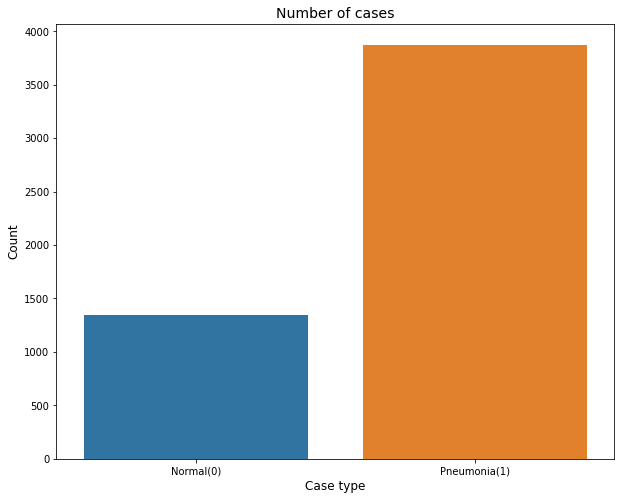

In [7]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

Dataset is very imbalance, so we need Aug, Overstampling or Understampling

Valid dataset

1    8
0    8
Name: label, dtype: int64


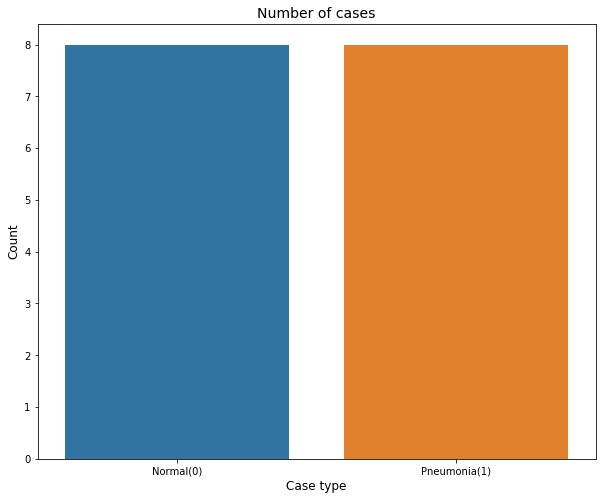

In [8]:
# Get the counts for each class
cases_count = valid_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

Test dataset

1    390
0    234
Name: label, dtype: int64


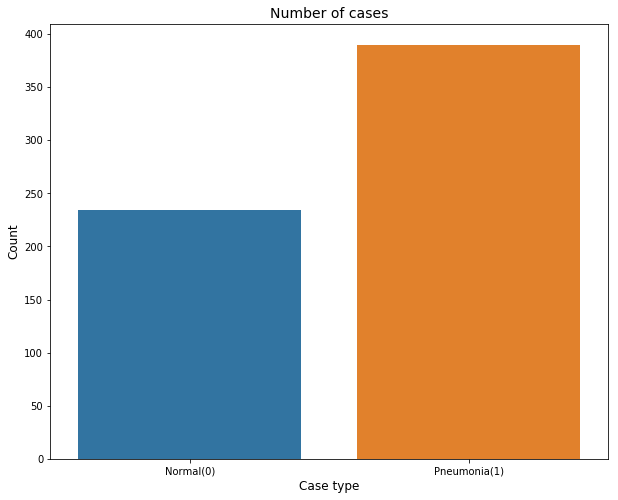

In [9]:
# Get the counts for each class
cases_count = test_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

**Create FudusDataset**

In [10]:
class FundusDataset(Dataset):
    
    def __init__(self, dataframe, image_size, normalization):
        """
        Init Dataset
        
        Parameters
        ----------
        dataframe: pandas.DataFrame
            dataframe contains all information of images
        image_size: int
            image size to rescale
        normalization: bool
            whether applying normalization with mean and std from ImageNet or not
        """
        self.image_paths = [] # List of image paths
        self.image_labels = [] # List of image labels
        
        # Define list of image transformations
        image_transformation = [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ]
        
        if normalization:
            # Normalization with mean and std from ImageNet
            image_transformation.append(transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD))
        
        self.image_transformation = transforms.Compose(image_transformation)
        
        # Get all image paths and image labels from dataframe
        for index, row in dataframe.iterrows():
            self.image_paths.append(row.path)
            self.image_labels.append(row.label)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        """
        Read image at index and convert to torch Tensor
        """
        
        # Read image
        image_path = self.image_paths[index]
        image_data = Image.open(image_path).convert("RGB") # Convert image to RGB channels
        
        # TODO: Image augmentation code would be placed here
        
        # Resize and convert image to torch tensor 
        image_data = self.image_transformation(image_data)
        
        return image_data, torch.tensor([self.image_labels[index]*1.0])

In [11]:
train_dataset = FundusDataset(train_data, IMAGE_SIZE, True)
valid_dataset = FundusDataset(valid_data, IMAGE_SIZE, True)
test_dataset = FundusDataset(test_data, IMAGE_SIZE, True)


Test dataset

In [12]:
for img, label in test_dataset:
    print(img.size())
    print(label)
    break

torch.Size([3, 224, 224])
tensor([1.])


**Create Dataloader**

In [13]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

In [14]:
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

In [15]:
for data, label in valid_dataloader:
    print(data.size())
    print(label.size())
    break

torch.Size([16, 3, 224, 224])
torch.Size([16, 1])


**Check GPU**

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**Define Model**

In [17]:
class ResNet50(nn.Module):
    def __init__(self, num_classes, is_trained=True):
        """
        Init model architecture
        
        Parameters
        ----------
        num_classes: int
            number of classes
        is_trained: bool
            whether using pretrained model from ImageNet or not
        """
        super().__init__()
        
        # Load the resnet50 from ImageNet
        self.net = torchvision.models.resnet50(pretrained=is_trained)
        
        # freeze False, unfreeze True
        #for param in self.net.parameters():
        #    param.require_grad = False
        
        # Get the input dimension of last layer
        kernel_count = self.net.fc.in_features
        
        # Replace last layer with new layer that have num_classes nodes, after that apply Sigmoid to the output
        self.net.fc = nn.Sequential(nn.Linear(kernel_count, num_classes), nn.Sigmoid())
        
    def forward(self, inputs):
        """
        Forward the netword with the inputs
        """
        return self.net(inputs)

 ** Create Model & count params**

In [18]:
model = ResNet50(num_classes=1).to(device)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 123443158.12it/s]


ResNet50(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(6

In [19]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

23510081

## Define loss function, optimizer, and learning rate scheduler

In [20]:
# Loss function
loss_criteria = nn.BCELoss()

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)

# Learning rate will be reduced automatically during training
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = LEARNING_RATE_SCHEDULE_FACTOR, patience = LEARNING_RATE_SCHEDULE_PATIENCE, mode = 'max', verbose=True)

## Compute F1 Score

In [21]:
def multi_label_f1(y_gt, y_pred):
    """ Calculate F1 for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        F1 of each class
    """
    f1_out = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = (y_pred.to("cpu").numpy() > 0.5) * 1.0
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        f1_out.append(f1_score(gt_np[:, i], pred_np[:, i]))
    return f1_out

## Training each epoc

In [22]:
def epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb):
    """
    Epoch training

    Paramteters
    -----------
    epoch: int
      epoch number
    model: torch Module
      model to train
    train_dataloader: Dataset
      data loader for training
    device: str
      "cpu" or "cuda"
    loss_criteria: loss function
      loss function used for training
    optimizer: torch optimizer
      optimizer used for training
    mb: master bar of fastprogress
      progress to log

    Returns
    -------
    float
      training loss
    """
    # Switch model to training mode
    model.train()
    training_loss = 0 # Storing sum of training losses
   
    # For each batch
    for batch, (images, labels) in enumerate(progress_bar(train_dataloader, parent=mb)):
        
        # Move X, Y  to device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear previous gradient
        optimizer.zero_grad()

        # Feed forward the model
        pred = model(images)
        loss = loss_criteria(pred, labels)

        # Back propagation
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update training loss after each batch
        training_loss += loss.item()

        mb.child.comment = f'Training loss {training_loss/(batch+1)}'

    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    # return training loss
    return training_loss/len(train_dataloader)

## Evaluate model

In [23]:
def evaluating(epoch, model, val_loader, device, loss_criteria, mb):
    """
    Validate model on validation dataset
    
    Parameters
    ----------
    epoch: int
        epoch number
    model: torch Module
        model used for validation
    val_loader: Dataset
        data loader of validation set
    device: str
        "cuda" or "cpu"
    loss_criteria: loss function
      loss function used for training
    mb: master bar of fastprogress
      progress to log
  
    Returns
    -------
    float
        loss on validation set
    float
        metric score on validation set
    """

    # Switch model to evaluation mode
    model.eval()

    val_loss = 0                                   # Total loss of model on validation set
    out_pred = torch.FloatTensor().to(device)      # Tensor stores prediction values
    out_gt = torch.FloatTensor().to(device)        # Tensor stores groundtruth values

    with torch.no_grad(): # Turn off gradient
        # For each batch
        for step, (images, labels) in enumerate(progress_bar(val_loader, parent=mb)):
            # Move images, labels to device (GPU)
            images = images.to(device)
            labels = labels.to(device)

            # Update groundtruth values
            out_gt = torch.cat((out_gt,  labels), 0)

            # Feed forward the model
            ps = model(images)
            loss = loss_criteria(ps, labels)

            # Update prediction values
            out_pred = torch.cat((out_pred, ps), 0)

            # Update validation loss after each batch
            val_loss += loss
            mb.child.comment = f'Validation loss {val_loss/(step+1)}'

    # Clear memory
    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    # return validation loss, and metric score
    return val_loss/len(val_loader), np.array(multi_label_f1(out_gt, out_pred)).mean()

## Fully Training

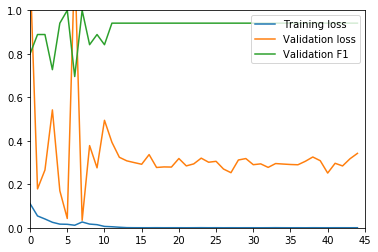

Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
Epoch    17: reducing learning rate of group 0 to 1.0000e-05.
Epoch    23: reducing learning rate of group 0 to 1.0000e-06.
Epoch    29: reducing learning rate of group 0 to 1.0000e-07.
Epoch    35: reducing learning rate of group 0 to 1.0000e-08.


In [24]:
# Best F1 value during training
best_score = 0
model_path = "resnet50.pth"
training_losses = []
validation_losses = []
validation_score = []


# Config progress bar
mb = master_bar(range(MAX_EPOCHS))
mb.names = ['Training loss', 'Validation loss', 'Validation F1']
x = []

# Training each epoch
for epoch in mb:
    mb.first_bar.comment = f'Best F1 score: {best_score}'
    x.append(epoch)

    # Training
    train_loss = epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb)
    mb.write('Finish training epoch {} with loss {:.4f}'.format(epoch, train_loss))
    training_losses.append(train_loss)

    # Evaluating
    val_loss, new_score = evaluating(epoch, model, valid_dataloader, device, loss_criteria, mb)
    mb.write('Finish validation epoch {} with loss {:.4f} and score {:.4f}'.format(epoch, val_loss, new_score))
    validation_losses.append(val_loss)
    validation_score.append(new_score)

    # Update learning rate
    lr_scheduler.step(new_score)

    # Update training chart
    mb.update_graph([[x, training_losses], [x, validation_losses], [x, validation_score]], [0,MAX_EPOCHS], [0,1])

    # Save model
    if best_score < new_score:
        mb.write(f"Improve F1 from {best_score} to {new_score}")
        best_score = new_score

        # Saving model: https://pytorch.org/tutorials/beginner/saving_loading_models.html
        torch.save(model.state_dict(), model_path)

## Testing result

In [25]:
def predict(image_data, model, device):
    """ Predict image
    
    Parameters
    ----------
    image_path: str
        image to predict
    model: nn.Module
        model used to predict
    device: str
        'cpu' or 'cuda'
        
    Returns
    -------
    str
        list of label indices
    """
    with torch.no_grad():
        ps = model(image_data.unsqueeze(0).to(device))
        ps = ps[0]
        if ps[0].item() > 0.5: # Threshold is 0.5
            return 1.
    return 0.

In [26]:
model.load_state_dict(torch.load(model_path))
model.eval()

ResNet50(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(6

In [27]:
count_truth = 0
count_img = 0
for img, label in test_dataset:
    if predict(img, model, device) == label[0]:
        count_truth+=1
    count_img+=1

print("Score = ",count_truth/count_img)

Score =  0.8125
